In [1]:
!pip install transformers accelerate xformers wandb datasets -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 86.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 101.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 31.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 1

## Setup


In [2]:
import json
import wandb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import torch
import torch.nn.functional as F
from huggingface_hub import login
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import Trainer, TrainingArguments

sns.set()
%matplotlib inline

In [3]:
sns.set_style("whitegrid", {"axes.grid": False})

In [4]:
# project name for wandb.ai
project_name = "Arabic-Weakly-Supervised-Propaganda-Detection"
run_name = "apl-nce-1.0-mae-1.0"

# defining data paths
# snorkel_data_path = "../data/processed/train.json"
# lf_dev_data_path = "../data/processed/lf_dev.json"
# test_data_path = "../data/processed/test_data.json"
# access_tokens_path = "../data/access_tokens.json"

# defining data paths
snorkel_data_path = "./train.json"
lf_dev_data_path = "./lf_dev.json"
test_data_path = "./test_data.json"
access_tokens_path = "./access_tokens.json"

# defining model names
seed = 42
model_ckpt = "UBC-NLP/MARBERT"
model_name = "marbert-weakly-supervised-arabic-propaganda"
model_path = f"./models/{model_name}"
# model_path = f"../models/{model_name}"

In [5]:
with open(access_tokens_path) as f:
    access_tokens = json.load(f)

In [6]:
login(access_tokens["huggingface"]["write_token"])

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## Data Preprocessing


In [7]:
data = pd.read_json(snorkel_data_path)
data.head(2)

,tweetid,text,label
0,1252315523897004032,مدحت نافع: انهيار أسعار النفط يصب فى مصلحة الا...,0
1,1036264255950139392,شاهد ..المدرب الإيطالي روبرتو مانشيني في جسد ر...,0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195840 entries, 0 to 195839
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   tweetid  195840 non-null  int64 
 1   text     195840 non-null  object
 2   label    195840 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 6.0+ MB


In [9]:
# splitting the data to 70-30 % portions
train, valid = train_test_split(
    data, train_size=0.70, stratify=data.label, random_state=seed
)

In [10]:
# loading the lf_dev data
lf_dev = pd.read_json(lf_dev_data_path)[data.columns]
lf_dev.head(2)

,tweetid,text,label
0,924924839902793728,RT : هو جنةبعيني.,0
1,1074734231887187970,ر٣ تركيا تجاهر بالمعاصي,1


In [11]:
# loading the test data
test = pd.read_json(test_data_path)[data.columns]
test.head(2)

,tweetid,text,label
0,977553193814122498,شاركوا معنا .. في ساعة الأرض الليلة ساعة واحد ...,0
1,1005856990436970497,RT : اللهم طهر قلوبنا من كل ضيق ويسر أمورنا في...,0


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420 entries, 0 to 419
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweetid  420 non-null    int64 
 1   text     420 non-null    object
 2   label    420 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 13.1+ KB


In [13]:
len(train), len(valid), len(lf_dev), len(test)

(137088, 58752, 500, 420)

In [14]:
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
lf_dev = lf_dev.reset_index(drop=True)
test = test.reset_index(drop=True)

## Tokenization


In [15]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [16]:
# transformimg from pandas to hugging face datasets

train = Dataset.from_pandas(train, split="train")
valid = Dataset.from_pandas(valid, split="valid")
lf_dev = Dataset.from_pandas(lf_dev, split="lf_development")
test = Dataset.from_pandas(test, split="test")

ds = DatasetDict(
    {"train": train, "validation": valid, "lf_development": lf_dev, "test": test}
)
ds

DatasetDict({
    train: Dataset({
        features: ['tweetid', 'text', 'label'],
        num_rows: 137088
    })
    validation: Dataset({
        features: ['tweetid', 'text', 'label'],
        num_rows: 58752
    })
    lf_development: Dataset({
        features: ['tweetid', 'text', 'label'],
        num_rows: 500
    })
    test: Dataset({
        features: ['tweetid', 'text', 'label'],
        num_rows: 420
    })
})

In [17]:
# remove retweet symbol
ds = ds.map(
    lambda x: {"text": [t.replace("RT :", "").strip() for t in x["text"]]},
    batched=True,
    remove_columns=["text"],
)

Map:   0%|          | 0/137088 [00:00<?, ? examples/s]

Map:   0%|          | 0/58752 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/420 [00:00<?, ? examples/s]

In [18]:
def tokenize_ds(field):
    return tokenizer(field["text"], truncation=True)

In [19]:
cols = ds["train"].column_names.copy()
cols.remove("label")
cols

['tweetid', 'text']

In [20]:
ds_encoded = ds.map(tokenize_ds, batched=True, remove_columns=cols)
ds_encoded

Map:   0%|          | 0/137088 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/58752 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/420 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 137088
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 58752
    })
    lf_development: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 500
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 420
    })
})

## Modeling


### Setup


In [21]:
def compute_scores(preds):
    logits, labels = preds
    pred = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, pred)
    f1 = f1_score(labels, pred)
    prec = precision_score(labels, pred)
    rec = recall_score(labels, pred)
    return {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}

In [22]:
label_names = ["Transparent", "Propaganda"]
id2label = {i: l for i, l in enumerate(label_names)}
label2id = {l: i for i, l in enumerate(label_names)}

In [23]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels=len(label_names),
    id2label=id2label,
    label2id=label2id,
    token=access_tokens["huggingface"]["read_token"],
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# loss params
alpha = 1.0
beta = 1.0

# training params
num_epochs = 1
batch_size = 32
training_steps = (len(ds["train"]) // batch_size) * num_epochs

In [25]:
training_args = TrainingArguments(
    output_dir=model_path,
    overwrite_output_dir=True,
    learning_rate=3e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=1e-3,
    warmup_ratio=0.1,
    eval_steps=training_steps // 3,
    save_steps=training_steps // 3,
    evaluation_strategy="steps",
    save_strategy="steps",
    log_level="error",
    # logging_steps=1,
    seed=seed,
    load_best_model_at_end=True,
)

### Training


In [26]:
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    if torch.cuda.device_count() > 1:
        device = torch.device("cuda:0")
    else:
        device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [27]:
# APL (Active Passive Loss)


class NormalizedCrossEntropy(torch.nn.Module):
    def __init__(self, num_classes, scale=1.0):
        super(NormalizedCrossEntropy, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, pred, labels):
        pred = F.log_softmax(pred, dim=1)
        label_one_hot = (
            torch.nn.functional.one_hot(labels, self.num_classes)
            .float()
            .to(self.device)
        )
        nce = -1 * torch.sum(label_one_hot * pred, dim=1) / (-pred.sum(dim=1))
        return self.scale * nce.mean()


class MeanAbsoluteError(torch.nn.Module):
    def __init__(self, num_classes, scale=1.0):
        super(MeanAbsoluteError, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, pred, labels):
        pred = F.softmax(pred, dim=1)
        label_one_hot = (
            torch.nn.functional.one_hot(labels, self.num_classes)
            .float()
            .to(self.device)
        )
        mae = 1.0 - torch.sum(label_one_hot * pred, dim=1)
        return self.scale * mae.mean()


class NCEandMAE(torch.nn.Module):
    def __init__(self, alpha, beta, num_classes):
        super(NCEandMAE, self).__init__()
        self.num_classes = num_classes
        self.nce = NormalizedCrossEntropy(scale=alpha, num_classes=num_classes)
        self.mae = MeanAbsoluteError(scale=beta, num_classes=num_classes)

    def forward(self, pred, labels):
        return self.nce(pred, labels) + self.mae(pred, labels)

In [28]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")  # [batch_size, num_labels]
        outputs = model(**inputs)
        logits = outputs.get("logits")  # [batch_size, num_labels]
        loss_fct = NCEandMAE(alpha=alpha, beta=beta, num_classes=len(label_names))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [29]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [30]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=ds_encoded["train"],
    eval_dataset=ds_encoded["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_scores,
)

In [31]:
wandb.login(key=access_tokens["wandb"]["login"])

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [32]:
wandb.init(project=project_name, name=f"{model_name}-{run_name}")

wandb: Currently logged in as: bateekalmutairi. Use `wandb login --relogin` to force relogin


In [33]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1428,0.438100,0.386999,0.806492,0.739006,0.460698,0.567571
2856,0.403000,0.385712,0.807156,0.652384,0.643038,0.647677
4284,0.362600,0.357250,0.821402,0.758524,0.516517,0.614554


TrainOutput(global_step=4284, training_loss=0.42415772410445296, metrics={'train_runtime': 1983.3812, 'train_samples_per_second': 69.118, 'train_steps_per_second': 2.16, 'total_flos': 3960331160837760.0, 'train_loss': 0.42415772410445296, 'epoch': 1.0})

In [34]:
trainer.evaluate(ds_encoded["lf_development"], metric_key_prefix="lf_dev")

{'lf_dev_loss': 0.18000546097755432,
 'lf_dev_Accuracy': 0.91,
 'lf_dev_Precision': 0.6363636363636364,
 'lf_dev_Recall': 0.14583333333333334,
 'lf_dev_F1': 0.23728813559322035,
 'lf_dev_runtime': 1.2166,
 'lf_dev_samples_per_second': 410.966,
 'lf_dev_steps_per_second': 13.151,
 'epoch': 1.0}

In [35]:
trainer.evaluate(ds_encoded["test"], metric_key_prefix="test")

{'test_loss': 0.1952429562807083,
 'test_Accuracy': 0.9023809523809524,
 'test_Precision': 0.4444444444444444,
 'test_Recall': 0.1,
 'test_F1': 0.163265306122449,
 'test_runtime': 1.0274,
 'test_samples_per_second': 408.796,
 'test_steps_per_second': 13.627,
 'epoch': 1.0}

In [36]:
test_outs = trainer.predict(ds_encoded["test"])
preds = np.argmax(test_outs[0], axis=-1)
labels = test_outs[1]

In [37]:
print(classification_report(labels, preds, target_names=label_names))

              precision    recall  f1-score   support

 Transparent       0.91      0.99      0.95       380
  Propaganda       0.44      0.10      0.16        40

    accuracy                           0.90       420
   macro avg       0.68      0.54      0.56       420
weighted avg       0.87      0.90      0.87       420



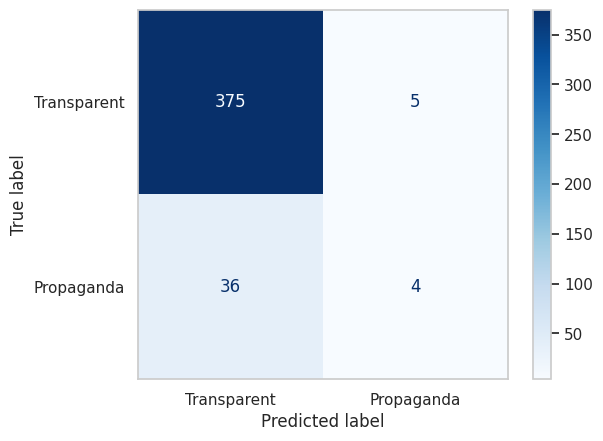

In [38]:
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)


disp.plot(cmap="Blues")
plt.show()

In [ ]:
# trainer.save_model(model_path)

In [ ]:
# trainer.push_to_hub()

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/651M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.54k [00:00<?, ?B/s]

'https://huggingface.co/Bmalmotairy/marbert-fully-supervised-arabic-propaganda/tree/main/'

In [39]:
wandb.finish()

eval/Accuracy,▁▁█
eval/F1,▁█▅
eval/Precision,▇▁█
eval/Recall,▁█▃
eval/loss,██▁
eval/runtime,█▂▁
eval/samples_per_second,▁▇█
eval/steps_per_second,▁▇█
test/Accuracy,▁
test/F1,▁
test/Precision,▁
